In [133]:
from selfies import decoder
import sys
sys.path.append('/Users/mac/research-yt/AlphaDrug/')

In [56]:
import pandas as pd
import selfies as sf

# 读取包含 SMILES 的 CSV 文件
csv_file = 'data/small_with_selfies.tsv'
selfies_column_name = 'selfies'

df = pd.read_csv(csv_file, sep='\t')
selfies = df[selfies_column_name].tolist()

alphabet = sf.get_alphabet_from_selfies(selfies)
sorted_alphabet = sorted(list(alphabet))

# 保存符号集到文件
with open('SELFIES_vocab.txt', 'w') as file:
    for symbol in sorted_alphabet:
        file.write(symbol + '\n')

print(f'Successfully saved SELFIES vocabulary to SELFIES_vocab.txt')

Successfully saved SELFIES vocabulary to SELFIES_vocab.txt


In [57]:
import json

# 读取 SELFIES_vocab.txt 文件内容
with open('SELFIES_vocab.txt', 'r', encoding='utf-8') as vocab_file:
    sel_voc_list = [line.strip() for line in vocab_file.readlines()]

# 读取 settings.json 文件
with open('experiment/test3/settings.json', 'r', encoding='utf-8') as json_file:
    settings = json.load(json_file)

# 更新 "selVoc" 键的值
settings['selVoc'] = sel_voc_list

# 将更新后的内容写回 settings.json 文件
with open('experiment/test3/settings.json', 'w', encoding='utf-8') as json_file:
    json.dump(settings, json_file, ensure_ascii=False, indent=4)

In [200]:
import numpy as np
import json
from rdkit import Chem
import selfies as sf

# 加载 JSON 数据
file_path = "experiment/test3/mps_freq_mcts_10_2024_12_11_15_26_20_30.pt_0_1a9u/res.json"  # 替换为实际文件路径
with open(file_path, 'r') as f:
    data = json.load(f)

# 提取嵌套数据
nested_scores = data['score']  # 嵌套的分数结构 (48 x 10)
nested_valid_smiles = data['allValidSelfies']  # 嵌套的有效 SMILES
nested_all_selfies = data['allSelfies']  # 嵌套的 SELFIES

# 展平嵌套结构
flat_scores = [score for sublist in nested_scores for score in sublist]
flat_valid_smiles = [smiles for sublist in nested_valid_smiles for smiles in sublist]
flat_all_selfies = [selfies for sublist in nested_all_selfies for selfies in sublist]

# 分数统计分析
mean_score = np.mean(flat_scores)
max_score = np.max(flat_scores)
min_score = np.min(flat_scores)

print(f"Total Score Data Points: {len(flat_scores)}")
print(f"Mean Score: {mean_score:.2f}")
print(f"Max Score: {max_score:.2f}")
print(f"Min Score: {min_score:.2f}")

Total Score Data Points: 457
Mean Score: 8.80
Max Score: 10.00
Min Score: 5.30


In [203]:
# 有效分子的统计信息
valid_smiles_count = len(flat_valid_smiles)
all_selfies_count = len(flat_all_selfies)
valid_smiles_ratio = valid_smiles_count / all_selfies_count * 100 if all_selfies_count > 0 else 0

print(f"Total SELFIES: {all_selfies_count}")
print(f"Valid SMILES: {valid_smiles_count}")
print(f"Valid SMILES Ratio: {valid_smiles_ratio:.2f}%")

Total SELFIES: 480
Valid SMILES: 457
Valid SMILES Ratio: 95.21%


In [127]:
# 总生成分子数
total_molecules = sum(len(sublist) for sublist in all_selfies)

# 有效分子数
valid_molecules = sum(len(sublist) for sublist in valid_selfies)

# 有效分子比例
valid_ratio = valid_molecules / total_molecules
print(f"Valid Molecule Ratio: {valid_ratio:.2%}")

Valid Molecule Ratio: 95.21%


In [204]:
# 保存有效的 SMILES 和 SELFIES
with open("valid_smiles_nested.txt", "w") as sm_file, open("all_selfies_nested.txt", "w") as sf_file:
    for smiles in flat_valid_smiles:
        sm_file.write(smiles + "\n")
    for selfies in flat_all_selfies:
        sf_file.write(selfies + "\n")

In [205]:
# 提取最高分对应的分子
if flat_scores:
    max_score_index = flat_scores.index(max_score)
    best_smiles = flat_valid_smiles[max_score_index] if max_score_index < len(flat_valid_smiles) else "N/A"
    print(f"Best SMILES (Max Score): {best_smiles}")
else:
    print("No score data available.")

Best SMILES (Max Score): NS(=O)(=O)C=C1C=CC(N2C=NC3=C(NC4=CC=CC=C4OC3)C2=N1)=C


In [206]:
# 可选：分析 SELFIES 的有效性
import selfies as sf
from rdkit import Chem

decoded_smiles = []
invalid_selfies = []

for selfies in flat_all_selfies:
    try:
        smiles = sf.decoder(selfies)
        decoded_smiles.append(smiles)
    except sf.DecoderError:
        invalid_selfies.append(selfies)

valid_selfies_ratio = len(decoded_smiles) / len(flat_all_selfies) * 100 if len(flat_all_selfies) > 0 else 0
print(f"Decoded SELFIES to SMILES Ratio: {valid_selfies_ratio:.2f}%")
print(f"Invalid SELFIES Count: {len(invalid_selfies)}")

Decoded SELFIES to SMILES Ratio: 100.00%
Invalid SELFIES Count: 0


In [207]:
# 保存无效 SELFIES
if invalid_selfies:
    with open("invalid_selfies_nested.txt", "w") as invalid_file:
        for selfies in invalid_selfies:
            invalid_file.write(selfies + "\n")
    print("Invalid SELFIES saved to 'invalid_selfies_nested.txt'.")

In [240]:
from rdkit import Chem
from rdkit.Chem import Descriptors, QED
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Crippen
import selfies as sf
import numpy as np
import json
import matplotlib.pyplot as plt
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

# 加载 JSON 数据
file_path = "experiment/test3/mps_freq_mcts_10_2024_12_11_15_26_20_30.pt_0_1a9u/res.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# 提取嵌套数据
nested_scores = data['score']
nested_valid_smiles = data['allValidSelfies']

# 展平嵌套数据
flat_scores = [score for sublist in nested_scores for score in sublist]
flat_valid_smiles = [smiles for sublist in nested_valid_smiles for smiles in sublist]

# 初始化属性存储
logp_values = []
qed_values = []
tpsa_values = []
num_rings = []
num_chiral_centers = []
murcko_scaffolds = set()

# 功能扩展：合成访问性分数 (Synthetic Accessibility, SA)
def synthetic_accessibility_score(mol):
    try:
        import sascorer
        return sascorer.calculateScore(mol)
    except ImportError:
        return None

# 遍历 SMILES
for smiles in flat_valid_smiles:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # LogP
        logp_values.append(Crippen.MolLogP(mol))
        
        # QED
        qed_values.append(QED.qed(mol))
        
        # TPSA (Topological Polar Surface Area)
        tpsa_values.append(Descriptors.TPSA(mol))
        
        # 环数量
        num_rings.append(rdMolDescriptors.CalcNumRings(mol))
        
        # 手性中心数量
        num_chiral_centers.append(len(Chem.FindMolChiralCenters(mol, includeUnassigned=True)))
        
        # Murcko Scaffold
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        murcko_scaffolds.add(Chem.MolToSmiles(scaffold))

# 属性统计
logp_mean = np.mean(logp_values)
qed_mean = np.mean(qed_values)
tpsa_mean = np.mean(tpsa_values)
rings_mean = np.mean(num_rings)
chiral_centers_mean = np.mean(num_chiral_centers)

print(f"LogP: Mean = {logp_mean:.2f}, Min = {min(logp_values):.2f}, Max = {max(logp_values):.2f}")
print(f"QED: Mean = {qed_mean:.2f}")
print(f"TPSA: Mean = {tpsa_mean:.2f}")
print(f"Number of Rings: Mean = {rings_mean:.2f}")
print(f"Number of Chiral Centers: Mean = {chiral_centers_mean:.2f}")
print(f"Number of Unique Murcko Scaffolds: {len(murcko_scaffolds)}")

# 多样性分析：计算平均 Tanimoto 相似性
from rdkit import DataStructs
from rdkit.Chem import AllChem

def calculate_diversity_matrix(smiles_list):
    # 创建 Morgan 指纹生成器
    morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)
    
    # 生成分子指纹
    fingerprints = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fingerprints.append(morgan_gen.GetFingerprint(mol))
    
    # 初始化相似性矩阵
    n = len(fingerprints)
    similarity_matrix = np.zeros((n, n))
    
    # 计算 Tanimoto 相似性
    for i in range(n):
        for j in range(i, n):  # 上三角矩阵
            similarity = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity  # 矩阵对称
    
    # 计算 Diversity 矩阵
    diversity_matrix = 1 - similarity_matrix
    
    return diversity_matrix, similarity_matrix

diversity_matrix, similarity_matrix = calculate_diversity_matrix(flat_valid_smiles)
mean_similarity = np.mean(similarity_matrix)
diversity_score = 1 - mean_similarity

print(f"Mean Tanimoto Similarity: {mean_similarity:.4f}")
print(f"Mean Molecular Diversity (1-Tanimoto Similarity): {diversity_score:.4f}")

LogP: Mean = 1.50, Min = -0.69, Max = 5.11
QED: Mean = 0.70
TPSA: Mean = 102.94
Number of Rings: Mean = 3.37
Number of Chiral Centers: Mean = 0.36
Number of Unique Murcko Scaffolds: 83
Mean Tanimoto Similarity: 0.2814
Mean Molecular Diversity (1-Tanimoto Similarity): 0.7186


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


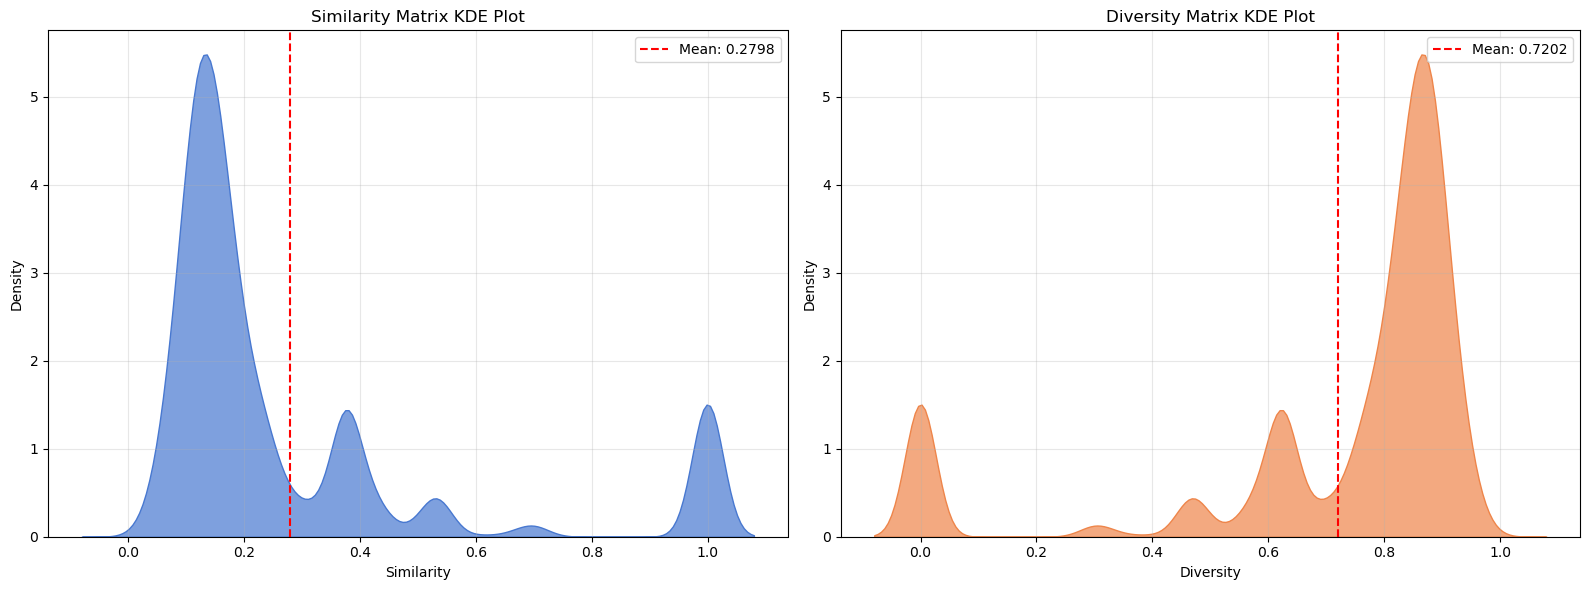

In [250]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_kde_distributions(similarity_matrix, diversity_matrix):
    # Flatten the upper triangle values (excluding diagonal)
    similarity_values = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
    diversity_values = diversity_matrix[np.triu_indices_from(diversity_matrix, k=1)]

    # 设置颜色
    colors = sns.color_palette("muted", 2)

    # 创建子图
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # KDE 相似性分布
    sns.kdeplot(similarity_values, fill=True, color=colors[0], ax=axes[0], alpha=0.7)
    axes[0].axvline(x=np.mean(similarity_values), color='red', linestyle='--', label=f"Mean: {np.mean(similarity_values):.4f}")
    axes[0].set_title("Similarity Matrix KDE Plot")
    axes[0].set_xlabel("Similarity")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # KDE 多样性分布
    sns.kdeplot(diversity_values, fill=True, color=colors[1], ax=axes[1], alpha=0.7)
    axes[1].axvline(x=np.mean(diversity_values), color='red', linestyle='--', label=f"Mean: {np.mean(diversity_values):.4f}")
    axes[1].set_title("Diversity Matrix KDE Plot")
    axes[1].set_xlabel("Diversity")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    # 调整布局并保存
    plt.tight_layout()
    plt.savefig("similarity_and_diversity_kde_plots.png")
    plt.show()

# 调用函数
plot_kde_distributions(similarity_matrix, diversity_matrix)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


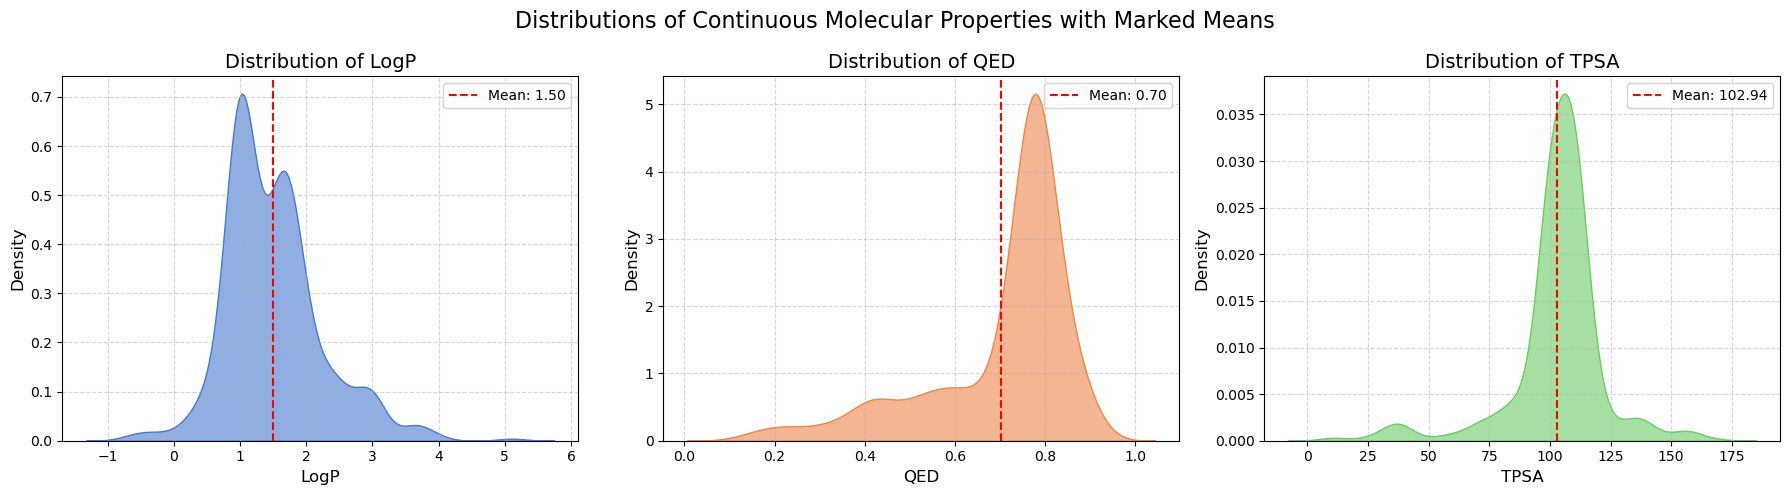

In [219]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 数据准备：仅选择连续变量
continuous_data = data[['LogP', 'QED', 'TPSA']]  # 选择连续变量

# 配色方案
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # 不同子图颜色
# colors = sns.color_palette("pastel", 3)
colors = sns.color_palette("muted", 3)

# 标记线位置（示例：均值值作为标记线）
mark_lines = {
    'LogP': np.mean(continuous_data['LogP']),
    'QED': np.mean(continuous_data['QED']),
    'TPSA': np.mean(continuous_data['TPSA']),
}

# 创建子图
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# 为每个连续变量绘制单独的分布图
for ax, (column, color) in zip(axes, zip(continuous_data.columns, colors)):
    sns.kdeplot(data=continuous_data, x=column, fill=True, color=color, alpha=0.6, ax=ax)
    ax.axvline(mark_lines[column], color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mark_lines[column]:.2f}')
    ax.set_title(f"Distribution of {column}", fontsize=14)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.5)

# 整体布局调整
plt.suptitle("Distributions of Continuous Molecular Properties with Marked Means", fontsize=16)
plt.tight_layout()
plt.savefig("continuous_properties_with_marked_lines.png")
plt.show()

In [226]:
import pandas as pd
from scipy.stats import ttest_ind
import numpy as np

# 数据准备：仅选择连续变量
continuous_data = data[['LogP', 'QED', 'TPSA']]  # 选择连续变量

# 计算均值
means = continuous_data.mean()

# 显著性分析（分组示例：高于均值 vs 低于均值）
significance_results = {}
for column in continuous_data.columns:
    # 分组数据
    high_group = continuous_data[continuous_data[column] >= means[column]][column]
    low_group = continuous_data[continuous_data[column] < means[column]][column]

    # T 检验
    t_stat, p_value = ttest_ind(high_group, low_group, equal_var=False)

    # 保存结果，保留四位有效小数
    significance_results[column] = {
        "Mean": round(means[column], 4),
        "T-Statistic": round(t_stat, 4),
        "P-Value": f"{p_value:.2e}"
    }

# 转换为 DataFrame
significance_df = pd.DataFrame.from_dict(significance_results, orient="index")

# 美化显示
significance_df = significance_df.rename(columns={
    "Mean": "Mean Value",
    "T-Statistic": "T-Statistic",
    "P-Value": "P-Value"
})

significance_df

,Mean Value,T-Statistic,P-Value
LogP,1.4972,24.5872,3.80e-76
QED,0.7025,23.1933,3.06e-49
TPSA,102.9376,15.5213,5.55e-41


/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


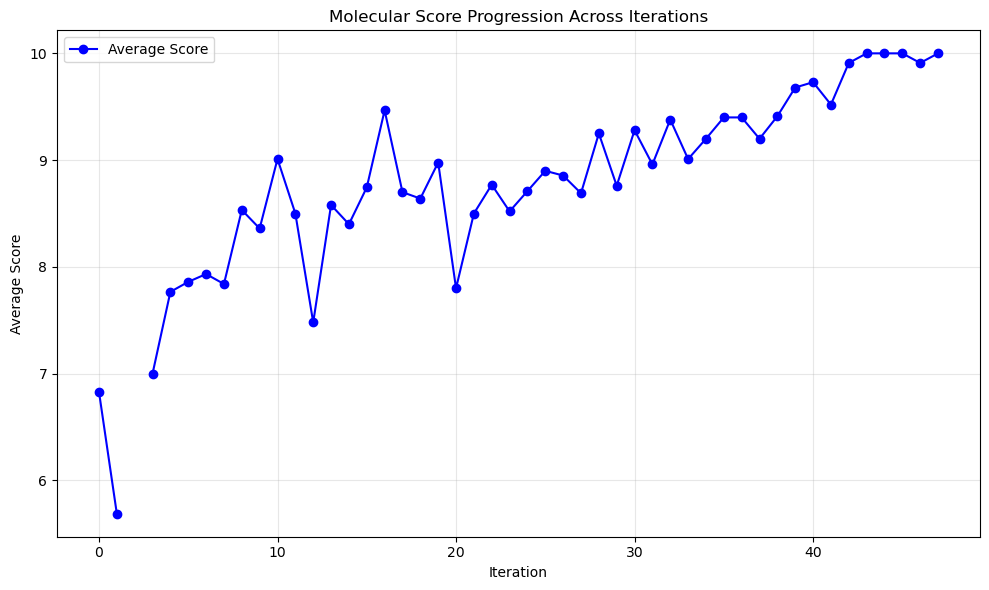

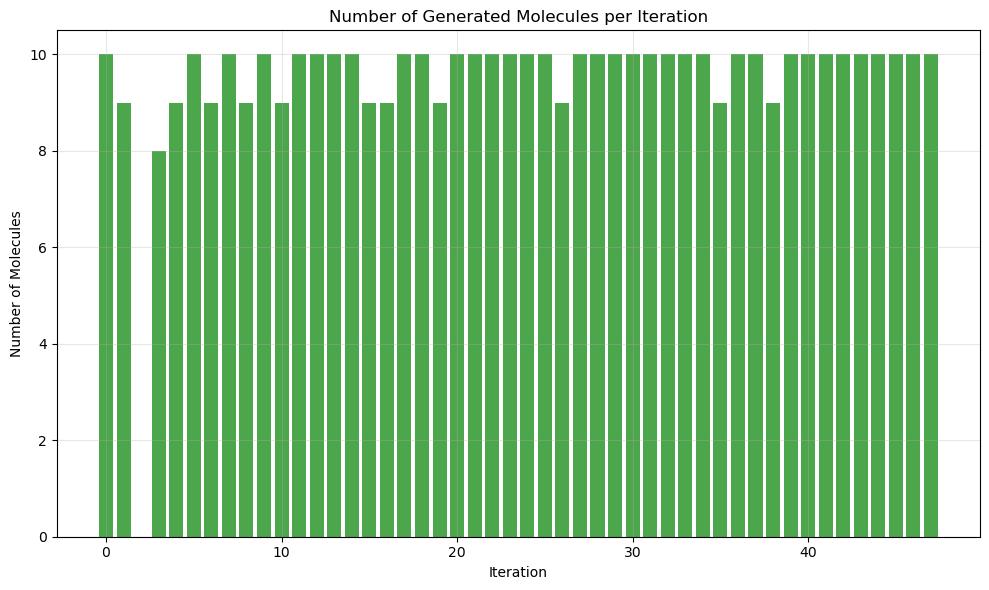

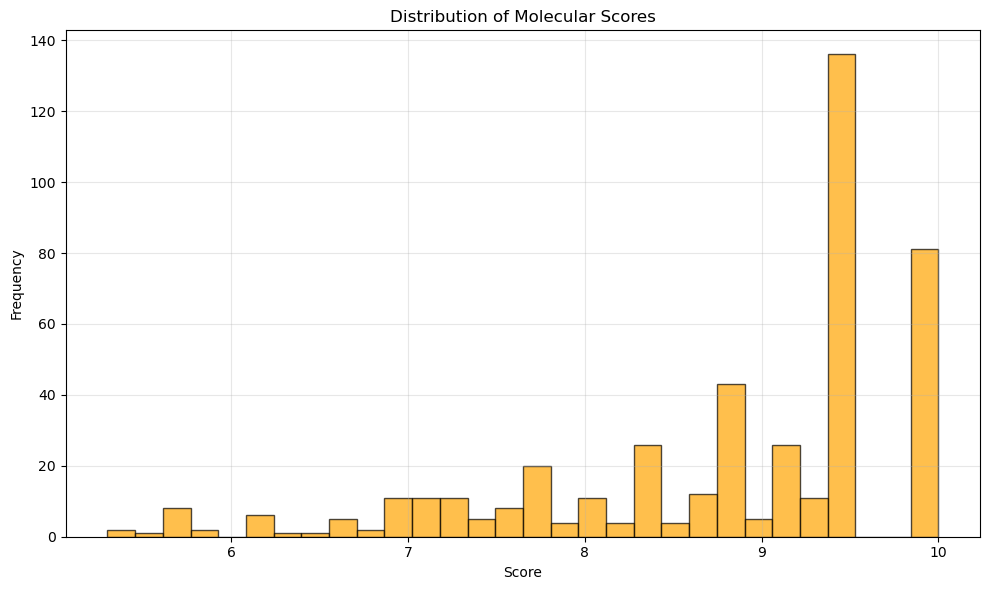

In [270]:
import json
import matplotlib.pyplot as plt
import numpy as np

# 加载 JSON 数据
file_path = "experiment/test3/mps_freq_mcts_10_2024_12_11_15_26_20_30.pt_0_1a9u/res.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# 提取嵌套数据
nested_scores = data['score']
nested_valid_smiles = data['allValidSelfies']

# 展平嵌套数据
flat_scores = [score for sublist in nested_scores for score in sublist]
flat_valid_smiles = [smiles for sublist in nested_valid_smiles for smiles in sublist]

# 统计每次迭代的分子得分均值
iteration_scores = [np.mean(sublist) for sublist in nested_scores]

# 统计每次迭代生成的分子数量
iteration_molecule_counts = [len(sublist) for sublist in nested_valid_smiles]

# 绘制分子得分变化
plt.figure(figsize=(10, 6))
plt.plot(range(len(iteration_scores)), iteration_scores, marker='o', linestyle='-', color='blue', label='Average Score')
plt.title('Molecular Score Progression Across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Average Score')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('molecular_score_progression.png')
plt.show()

# 绘制生成分子数量变化
plt.figure(figsize=(10, 6))
plt.bar(range(len(iteration_molecule_counts)), iteration_molecule_counts, color='green', alpha=0.7)
plt.title('Number of Generated Molecules per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Number of Molecules')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('molecule_count_progression.png')
plt.show()

# 分布统计：所有分子得分的直方图
plt.figure(figsize=(10, 6))
plt.hist(flat_scores, bins=30, color='orange', edgecolor='black', alpha=0.7)
plt.title('Distribution of Molecular Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('score_distribution.png')
plt.show()

In [276]:
# 加载 JSON 数据
file_path = "experiment/test3/mps_freq_mcts_10_2024_12_11_15_26_20_30.pt_0_1a9u/res.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# 提取 finalSelfies
final_selfies = data["finalSelfies"]
molecules = []

# SELFIES 转换为 SMILES 并生成分子对象
try:
    smiles = sf.decoder(final_selfies)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mol = Chem.AddHs(mol)  # 添加氢原子
        AllChem.EmbedMolecule(mol, AllChem.ETKDG())  # 生成 3D 坐标
        molecules.append((smiles, mol))
except Exception as e:
    print(f"Error decoding SELFIES: {final_selfies}, Error: {e}")

print(f"Generated {len(molecules)} molecules from finalSelfies.")

Generated 1 molecules from finalSelfies.


In [277]:
from rdkit.Chem import rdmolfiles
import os

output_dir = "generated_molecules"
os.makedirs(output_dir, exist_ok=True)

for i, (smiles, mol) in enumerate(molecules):
    file_path = os.path.join(output_dir, f"molecule_{i+1}.pdb")
    rdmolfiles.MolToPDBFile(mol, file_path)

print(f"Saved {len(molecules)} molecules to {output_dir}.")

Saved 1 molecules to generated_molecules.


In [278]:
import subprocess

protein_path = "data/test_pdbs/1a9u/1a9u_protein.pdb"
ligand_reference = "data/test_pdbs/1a9u/1a9u_ligand.sdf"
docking_results_dir = "docking_results"
os.makedirs(docking_results_dir, exist_ok=True)

for i, (smiles, mol) in enumerate(molecules):
    ligand_path = os.path.join(output_dir, f"molecule_{i+1}.pdb")
    output_path = os.path.join(docking_results_dir, f"molecule_{i+1}_docking.pdb")
    command = [
        "smina",
        "-r", protein_path,
        "-l", ligand_path,
        "--autobox_ligand", ligand_reference,
        "--autobox_add", "10",
        "--seed", "1000",
        "--exhaustiveness", "9",
        "--out", output_path
    ]
    subprocess.run(command)
print("Docking completed.")

*** Open Babel Warning  in ReadMolecule
  Failed to kekulize aromatic bonds in MOL file (title is 1a9u_ligand)



   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 1000

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1     